In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import Utils

2024-05-26 15:57:44.940622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:57:44.940720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:57:44.942516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 15:57:44.955242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 15:57:46.342875: W tensorflow/compiler/tf2

In [5]:
# tamanho da amostra
tamanho = 1e8
variancia = 1
code_rate = 4/7
# amostra
tamanho_amostra = 10**3
Eb_dB_values = np.arange(-2, 11, 1)

# ML data

# Gerar dados de treinamento
word_length = 4 # Tamanho padrão da entrada do hamming
training_sample_length = 10 **3
epoches = 200
training_noisy_data = []
training_original_data = []
batch_size = 16

training_data = {
    'original': [],
    'noisy': [],
    'info': []
}
training_information = network.get_training_data_set(training_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db, variancia)
    training_data['info'].append(info)
    training_data['noisy'].extend(info['split_encoded_data'])
    training_data['original'].extend(info['split_original_data'])

training_data['original'] = np.array(training_data['original'])
training_data['noisy'] = np.array(training_data['noisy'])


In [3]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)

Epoch 1/200
204/204 [==============================] - 3s 9ms/step - loss: 0.2123 - accuracy: 0.4972 - val_loss: 0.1433 - val_accuracy: 0.5791
Epoch 2/200
204/204 [==============================] - 2s 8ms/step - loss: 0.1351 - accuracy: 0.4825 - val_loss: 0.1240 - val_accuracy: 0.7582
Epoch 3/200
204/204 [==============================] - 2s 8ms/step - loss: 0.1148 - accuracy: 0.4748 - val_loss: 0.1125 - val_accuracy: 0.4372
Epoch 4/200
204/204 [==============================] - 2s 8ms/step - loss: 0.1003 - accuracy: 0.5246 - val_loss: 0.0894 - val_accuracy: 0.4262
Epoch 5/200
204/204 [==============================] - 2s 8ms/step - loss: 0.0904 - accuracy: 0.5046 - val_loss: 0.0849 - val_accuracy: 0.4834
Epoch 6/200
204/204 [==============================] - 2s 8ms/step - loss: 0.0805 - accuracy: 0.4923 - val_loss: 0.0713 - val_accuracy: 0.5646
Epoch 7/200
204/204 [==============================] - 2s 8ms/step - loss: 0.0758 - accuracy: 0.4794 - val_loss: 0.0687 - val_accuracy: 0.4289

KeyboardInterrupt: 

In [4]:
autoencoder = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)


Epoch 1/200
204/204 [==============================] - 4s 8ms/step - loss: 0.6564 - accuracy: 0.2674 - val_loss: 0.6111 - val_accuracy: 0.3068
Epoch 2/200
204/204 [==============================] - 1s 6ms/step - loss: 0.5691 - accuracy: 0.3092 - val_loss: 0.5234 - val_accuracy: 0.3188
Epoch 3/200
204/204 [==============================] - 1s 6ms/step - loss: 0.4809 - accuracy: 0.3098 - val_loss: 0.4409 - val_accuracy: 0.3403
Epoch 4/200
204/204 [==============================] - 1s 6ms/step - loss: 0.4004 - accuracy: 0.4009 - val_loss: 0.3624 - val_accuracy: 0.4717
Epoch 5/200
204/204 [==============================] - 1s 5ms/step - loss: 0.3359 - accuracy: 0.5228 - val_loss: 0.3124 - val_accuracy: 0.5249
Epoch 6/200
204/204 [==============================] - 1s 6ms/step - loss: 0.2954 - accuracy: 0.5363 - val_loss: 0.2791 - val_accuracy: 0.5138
Epoch 7/200
204/204 [==============================] - 1s 6ms/step - loss: 0.2656 - accuracy: 0.5105 - val_loss: 0.2511 - val_accuracy: 0.5086

In [6]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [7]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 3
test_information = network.get_training_data_set(test_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['info'].append(info)
    test_data['original'] = info['original_data']

In [8]:
i = 0
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))

1/1 [==============================] - 0s 27ms/step


In [9]:
i = 1
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 33ms/step


In [10]:
i = 2
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 26ms/step


In [11]:
i = 3
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 24ms/step


In [12]:
i = 4
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 33ms/step


In [13]:
i = 5
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 24ms/step


In [14]:
i = 6
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 25ms/step


In [15]:
i = 7
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 25ms/step


In [16]:
i = 8
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 26ms/step


In [17]:
i = 9
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 38ms/step


In [18]:
i = 10
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 33ms/step


In [19]:
i = 11
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 26ms/step


In [20]:
i = 12
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
#ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))


1/1 [==============================] - 0s 25ms/step


In [21]:
for i in test_data['info']:
    tradicional_result.append(HammingCode.decode_sample(i['split_encoded_data']))

In [22]:
BER_tradicional = []
BER_autoencoder = []
BER_ML = []
for i in range(0, len(Eb_dB_values)):
 #   BER_ML.append(np.sum(np.array(ML_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_tradicional.append(np.sum(np.array(tradicional_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_autoencoder.append(np.sum(np.array(autoencoder_result[i]).astype(int) != test_data['original']) / len(test_data['original']))

def adjust_ber(snr):
    adjusted_values = []
    for value in snr:
        correction = value * code_rate
        adjusted_values.append(np.sqrt(correction))
        
    return adjusted_values

#BER_ML = adjust_ber(BER_ML)
BER_tradicional = adjust_ber(BER_tradicional)
BER_autoencoder = adjust_ber(BER_autoencoder)

# Calcular a BER teórica
Eb_values = 10**(Eb_dB_values / 10)
BER_teorica = 0.5 * erfc(np.sqrt(Eb_values))

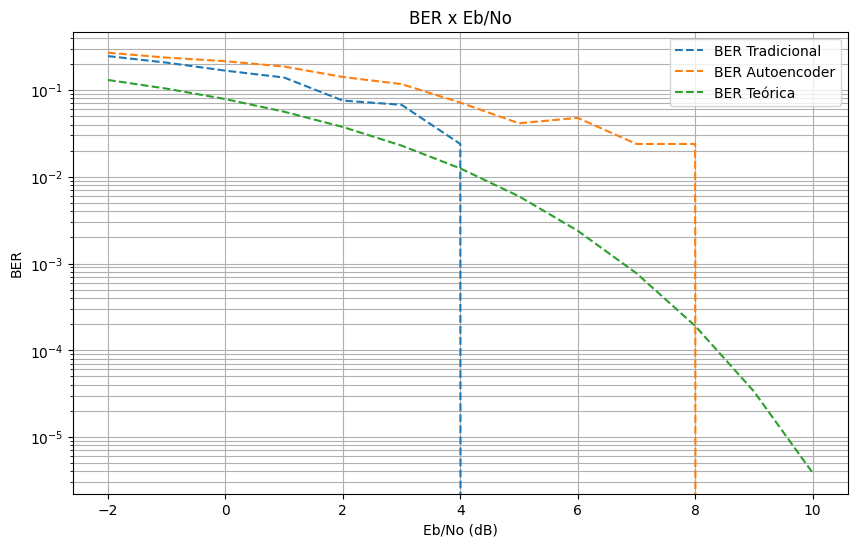

In [23]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_dB_values, BER_tradicional, linestyle = '--', label='BER Tradicional')
plt.semilogy(Eb_dB_values, BER_autoencoder, linestyle = '--', label='BER Autoencoder')
#plt.semilogy(Eb_dB_values, BER_ML, linestyle = '--', label='BER MLP')
plt.semilogy(Eb_dB_values, BER_teorica, linestyle='--', label='BER Teórica')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()